In [1]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

import warnings 
warnings.filterwarnings("ignore")

from fastai2.vision.all import *

from src.data.dls import build_dataloaders
from src.metrics.map import calculate_image_precision
from src.model.FasterRCNN import get_faster_rcnn

%load_ext autoreload
%autoreload 2

#### 1. Get DataLoaders

In [2]:
data_path = '/userhome/34/h3509807/wheat-data'

In [3]:
dls = build_dataloaders(data_path, resize_sz = 256, 
                        norm = False, rand_seed = 144)

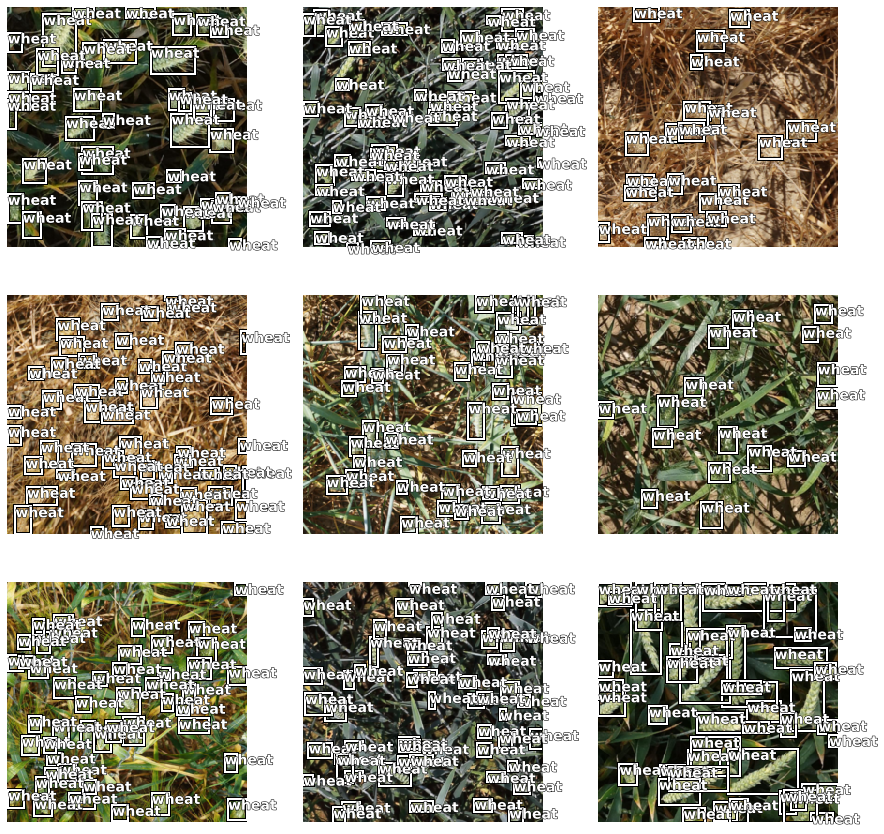

In [4]:
dls.show_batch(figsize = (15, 15))

In [5]:
# batch = (TensorImage, TensorBBox, TensorMultiCategory)
# TensorBBox: [BS, MAX BBOX NUMBER, 4]
# TensorMultiCategory: [BS, MAX BBOX NUMBER]
b = dls.one_batch()
type(b), type(b[0]), type(b[1]), type(b[2])

(tuple,
 fastai2.torch_core.TensorImage,
 fastai2.vision.core.TensorBBox,
 fastai2.torch_core.TensorMultiCategory)

In [6]:
b[0].shape, b[1].shape, b[2].shape

(torch.Size([64, 3, 256, 256]), torch.Size([64, 90, 4]), torch.Size([64, 90]))

In [7]:
b[0][0, 0, :3, :3]

tensor([[0.5922, 0.5529, 0.3216],
        [0.4510, 0.2667, 0.1843],
        [0.0941, 0.0784, 0.0863]], device='cuda:0')

#### 2. Setup Model

In [8]:
model = get_faster_rcnn()

#### 3. Setup Dummy Loss Function

In [9]:
import torch
import torch.nn as nn

In [10]:
class WeightedMultiLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, preds, tgts, **kwargs):
        loss = 0.
        for _, ind_loss in preds.items():
            loss += ind_loss
        return loss

In [11]:
multi_loss = WeightedMultiLoss()

In [12]:
isinstance(multi_loss, nn.Module)

True

#### 4. Freezing Selected Layers
- model.backbone
- model.rpn
- model.roi_heads

In [13]:
isinstance(model.roi_heads, nn.Module)

True

In [24]:
def _faster_rcnn_split(m):
    return L(m.backbone, m.rpn, m.roi_heads).map(params)

#### 5. Setup Metrics

In [25]:
from functools import partial

In [26]:
thresholds = [i for i in map(lambda i: i/100, range(50, 80, 5))]
thresholds

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

In [27]:
map_getter = partial(calculate_image_precision, thresholds = thresholds)

#### 6. Setup Callback
- begin_batch: rearange target from tensor to list of dict
- after_pred: sort predicted bboxes by confidence score (descending order)

In [ ]:
from pdb import set_trace

In [68]:
class EssentialCallback(Callback):
    """ essential changes for fastai2 Learner to interface with torchvision FasterRCNN """
    def begin_batch(self):
        """ 
        set yb = [{'boxes': tensor(BS, 4), 'labels': tensor(BS)}, ...]
        """
        yb = []
        
        bboxs_b, cats_b = self.learn.yb
        for bboxs, cats in zip(bboxs_b, cats_b):
            idxs = torch.where(cats != 0)
            tmp_dict = {'boxes': bboxs[idxs], 'labels': cats[idxs]}
            yb.append(tmp_dict)
            
        self.learn.yb = yb
        return None
        
        
    def after_pred(self):
        preds = self.learn.pred
        set_trace()

#### 7. Setup Learner

In [69]:
learn = Learner(dls, model, 
               loss_func = multi_loss, 
               splitter = _faster_rcnn_split,
               metrics = map_getter,
               cbs = EssentialCallback())

#### 8. Find Optimal Learning Rate

In [ ]:
learn.lr_find()

#### 9. Train + Unfreeze All Layers Except Backbone

In [70]:
learn.fit(n_epoch = 1, lr = 0.0001)

> <ipython-input-68-6cf670cf902f>(15)begin_batch()
-> return None
(Pdb) l
 10  	            yb.append(tmp_dict)
 11  	
 12  	        self.learn.yb = yb
 13  	
 14  	        set_trace()
 15  ->	        return None
 16  	
 17  	
 18  	    def after_pred(self):
 19  	        preds = self.learn.pred
 20  	        set_trace()
(Pdb) yb
[{'boxes': tensor([[-0.2031, -0.2227, -0.0781,  0.0000],
        [-0.0469,  0.6797,  0.0977,  0.8848],
        [-0.1816, -0.6816, -0.0352, -0.4980],
        [-1.0000, -0.1289, -0.9121,  0.0254],
        [-0.5293, -0.0625, -0.3828,  0.1133],
        [ 0.9199, -0.1895,  1.0000,  0.0312],
        [ 0.8711,  0.2285,  0.9668,  0.3750],
        [ 0.8848, -0.6250,  0.9863, -0.3965],
        [ 0.7402, -0.8496,  0.9844, -0.7070],
        [ 0.4277,  0.1426,  0.6016,  0.2461],
        [-0.8711, -0.1504, -0.6934, -0.0488],
        [-1.0000,  0.1973, -0.8730,  0.2871],
        [ 0.6875, -0.6621,  0.8223, -0.4863],
        [ 0.1621, -0.8164,  0.3516, -0.6309],
        [ 0.1

(Pdb) len(yb)
64
(Pdb) yb[0]['bboxes']
*** KeyError: 'bboxes'
(Pdb) yb[0]['boxes']
tensor([[-0.2031, -0.2227, -0.0781,  0.0000],
        [-0.0469,  0.6797,  0.0977,  0.8848],
        [-0.1816, -0.6816, -0.0352, -0.4980],
        [-1.0000, -0.1289, -0.9121,  0.0254],
        [-0.5293, -0.0625, -0.3828,  0.1133],
        [ 0.9199, -0.1895,  1.0000,  0.0312],
        [ 0.8711,  0.2285,  0.9668,  0.3750],
        [ 0.8848, -0.6250,  0.9863, -0.3965],
        [ 0.7402, -0.8496,  0.9844, -0.7070],
        [ 0.4277,  0.1426,  0.6016,  0.2461],
        [-0.8711, -0.1504, -0.6934, -0.0488],
        [-1.0000,  0.1973, -0.8730,  0.2871],
        [ 0.6875, -0.6621,  0.8223, -0.4863],
        [ 0.1621, -0.8164,  0.3516, -0.6309],
        [ 0.1211,  0.7188,  0.2012,  0.8555],
        [ 0.5137, -0.1562,  0.6250,  0.0469],
        [-1.0000,  0.5488, -0.9277,  0.6621],
        [-0.0391, -0.4805,  0.0664, -0.3320],
        [-0.2305,  0.7031, -0.1211,  0.8652],
        [-0.7695, -0.5723, -0.6758, -0.4434

(Pdb) exit


BdbQuit: 

In [ ]:
# learn.create_opt()
# learn.opt.freeze_to(-1) # freeze except last param groups
# learn.opt.param_groups[-1]
# learn.opt.freeze_to(-2) # freeze except last two param groups
# learn.opt.param_groups[-2]